In [1]:
#Training the model on 30k datasets.

import random
import numpy as np
from Bio import SeqIO
import gzip
import os
import pickle
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

#Set random seeds for reproducibility.
np.random.seed(4)
random.seed(5)
set_random_seed(4) 



def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X


Using TensorFlow backend.


In [ ]:
#TRAIN
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
average_score = np.zeros(len(protein_list))
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


for training_set_number in range (3):
        
    score_list = []
    
    if not os.path.exists("results/set_%s" % training_set_number):
        os.makedirs("results/set_%s" % training_set_number)
    
    for protein in protein_list:
        
        if not os.path.exists("results/set_%s/%s" % (training_set_number,protein)):
            os.makedirs("results/set_%s/%s" % (training_set_number,protein))
    
        print (protein)

        data_sources, X = load_data_sources(protein, 'train', training_set_number, *experiment_set)
        y = get_class(protein,"train",training_set_number)
        size = X.shape[2]
        score = []
        
        model = Sequential()
        model.add(Conv1D(60,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
        model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
        model.add(Conv1D(60, 4, activation='relu'))
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
        model.add(Conv1D(60, 4, activation='relu'))
        model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
        model.add(Conv1D(60, 3, activation='relu'))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(2, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/" + protein + "_weights.hdf5", verbose=0, save_best_only=True)
        earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        X_train = X
        y_train = y

        metrics = model.fit(X_train, y_train, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

      
        #Save score list
        with open ("results/set_%s/%s/score" % (training_set_number, protein), "w") as score_file:
            np.save(("results/set_%s/%s/score" % (training_set_number, protein)), score)
        
        #Save model and weights to .json file.
        json_model = model.to_json()
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "w") as json_file:
            json_file.write(json_model)
        with open ("results/set_%s/%s/weights.h5" % (training_set_number, protein), "w") as weights_file:
            model.save_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
        
        #Save the model metrics generated with model fit.
        with open ("results/set_%s/%s/metrics" % (training_set_number, protein), "w") as pickle_file:
            pickle.dump(metrics, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
#TEST
from keras.models import model_from_json

# Run predictions on all of the 3 test datasets.
for training_set_number in range (3):
    for protein in protein_list:
       
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            loaded_model = model_from_json(json)
            loaded_model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))


        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)


        #Run predictions on test dataset and save them.
        predictions = loaded_model.predict(X_test)
                                              
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "w") as predictions_file:
            np.save(predictions_file, predictions)



1_PARCLIP_AGO1234_hg19


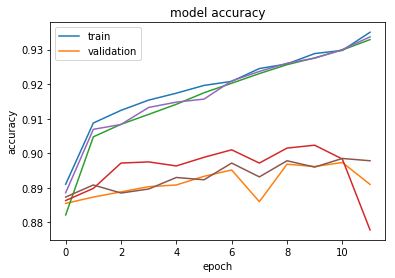

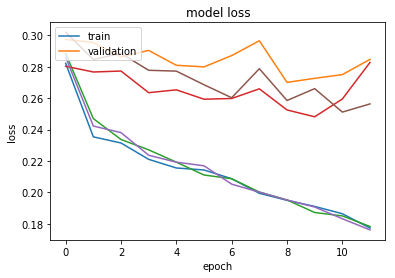

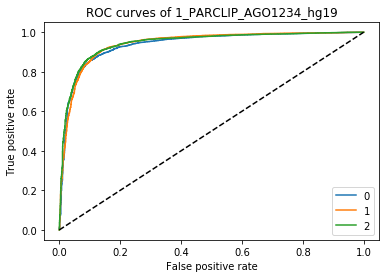

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 1_PARCLIP_AGO1234_hg19, with the average AUC of 0.9415269374999999 across all three datasets.
2_PARCLIP_AGO2MNASE_hg19


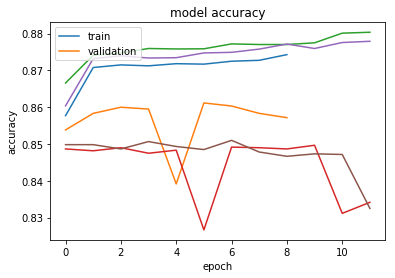

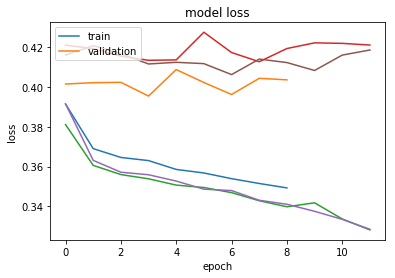

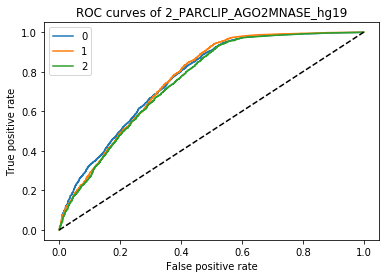

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 2_PARCLIP_AGO2MNASE_hg19, with the average AUC of 0.7638940208333332 across all three datasets.
3_HITSCLIP_Ago2_binding_clusters


ResourceExhaustedError: OOM when allocating tensor of shape [3,60,60] and type float
	 [[node training_7/Adam/zeros_18 (defined at /home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:702)  = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [3,60,60] values: [[0 0 0...]]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'training_7/Adam/zeros_18', defined at:
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/local/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-954308d047b5>", line 13, in <module>
    metrics = pickle.load(pickle_file)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/pickle.py", line 1384, in load
    return Unpickler(file).load()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/pickle.py", line 864, in load
    dispatch[key](self)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/pickle.py", line 1223, in load_build
    setstate(state)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/network.py", line 1266, in __setstate__
    model = saving.unpickle_model(state)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/saving.py", line 435, in unpickle_model
    return _deserialize_model(f)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/saving.py", line 317, in _deserialize_model
    model._make_train_function()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/optimizers.py", line 488, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 702, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1563, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2979, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [3,60,60] and type float
	 [[node training_7/Adam/zeros_18 (defined at /home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:702)  = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [3,60,60] values: [[0 0 0...]]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


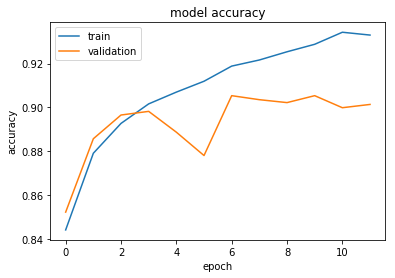

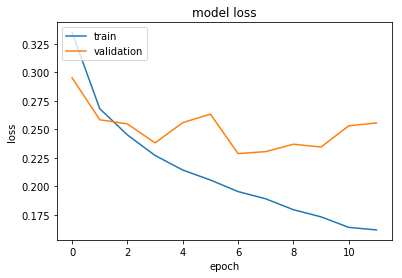

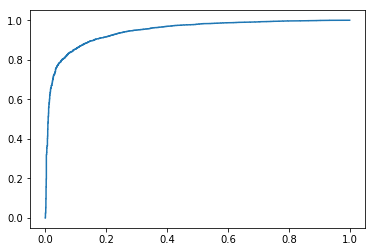

In [2]:
# Plot accuracy, loss values and ROC.

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

for protein in protein_list:
    average_score = np.zeros(3)
    print (protein)

    for training_set_number in range (3):
        #Load the model metrics generated with model fit.
        
        with open ("results/set_%s/%s/metrics" % (training_set_number, protein), "r") as pickle_file:
            metrics = pickle.load(pickle_file)
        
            # Plot history for accuracy.                
            plt.figure (1)
            plt.plot(metrics.history['acc'])
            plt.plot(metrics.history['val_acc'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            

            # Plot loss function history.
            plt.figure (2)
            plt.plot(metrics.history['loss'])
            plt.plot(metrics.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
          

        #Load model predictions.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "r") as predictions_file:
            loaded_predictions = np.load (predictions_file)

            # Evaluate model performance.
            y_scores = loaded_predictions [:,0:1]
            y_test = get_class(protein,"test",training_set_number)
            y_test = y_test [:,0:1]

            score = roc_auc_score(y_test, y_scores)

            fpr, tpr, thresholds = roc_curve(y_test, y_scores)
         
       
            #ROC plot
            plt.figure(3)
            plt.plot(fpr, tpr)
       
                 
        average_score[training_set_number] = score
    
    plt.figure(3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curves of %s' %protein)
    plt.legend(["0","1","2"], loc='best')
    plt.show()
    print ("Plots of accuracy, loss function during traing and a ROC curve of model's predictions on %s, with the average AUC of %s across all three datasets." % (protein, np.mean(average_score)))
   
    plt.close('all')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None):
    """

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('PuBu')

    plt.figure(figsize=(8, 6))
    plt.imshow((cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
  
    
for protein in protein_list:
    complete_predictions = []
    complete_y_test = []

    for training_set_number in range (3):
        
        #Load the model predictions of test datast.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "r") as predictions_file:
            prediction = np.load(predictions_file)

            #Read the index of the highest number from the arrays; 0 means there was no binding, 1 means there was protein bound
            binary_prediction = np.argmax(prediction,axis=1)

            #y_test = np.argmax(y_test, axis=1)
            y_test = get_class(protein,"test",training_set_number)[:,1]
            y_test
            

            complete_predictions.append(binary_prediction[:])
            complete_y_test.append(y_test[:])
            

    complete_predictions = np.ravel(complete_predictions)
    complete_y_test = np.ravel(complete_y_test) 
       
  
    cm = confusion_matrix(complete_y_test, complete_predictions)
    # Outputs an array with [tn, fp], [fn, tp]
    
    
    cm = np.flip(cm, 0)
    cm = np.flip(cm, 1)

    
    plot_confusion_matrix(cm, target_names = ['binding', 'no-binding'], 
                      title = "Confusion Matrix of %s" % (protein),
                      cmap = 'PuBu')
       
            


In [ ]:
from matplotlib_venn import venn2

# find indices of different predictions.
def find_fp_index(true_label, predicted_label):
    fp_indices = []
    for i in range (len(predicted_label)):
        if predicted_label[i] == 1 and true_label[i] == 0:
            fp_indices.append(i)
    return np.array(fp_indices)

def find_fn_index(true_label, predicted_label):
    fn_indices = []
    for i in range (len(predicted_label)):
        if predicted_label[i] == 0 and true_label[i] == 1:
            fn_indices.append(i)
    return np.array(fn_indices)

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

    
for protein in protein_list:
    complete_predictions = []
    complete_y_test = []
    complete_ideep = []
    binary_prediction = np.zeros(30000)
    binary_ideep = np.zeros(30000)
    
    
    print (protein)
    
    for training_set_number in range (3):

        # Load the model predictions of test datast.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "r") as predictions_file:
            prediction = np.load(predictions_file)          
            
            y_test = get_class(protein,"test",training_set_number)[:,1]
                        
            # Generated binary values are appended to a new array.
            complete_predictions.append(prediction[:,1])
            complete_y_test.append(y_test[:])
            
            predictions_ravel = np.ravel(complete_predictions)
            
            # Read the index of the highest number from the arrays; 0 means there was no binding, 1 means there was protein bound
            for i in range (len(predictions_ravel)):
                            if predictions_ravel[i] > 0.50:
                                binary_prediction[i] = 1
                            else:
                                binary_prediction[i] = 0
            
        with open ("ideep_results/predictions%s/%s" % (training_set_number, protein), "r") as ideep_file:
            ideep_prediction = np.loadtxt(ideep_file, delimiter="\n", unpack=False)
            ideep_prediction = np.array(ideep_prediction)
                        
            complete_ideep.append(ideep_prediction[:])
            
            ideep_ravel = np.ravel(complete_ideep)
            
            for i in range (len(ideep_ravel)):
                if ideep_ravel[i] > 0.50:
                    binary_ideep[i] = 1
                else:
                    binary_ideep[i] = 0
            
            
            
    
    binary_prediction = np.ravel(binary_prediction)
    complete_y_test = np.ravel(complete_y_test)
    binary_ideep = np.ravel(binary_ideep)
    #print (len(binary_ideep),len(binary_prediction))
    
    # Indices of false positives and false negatives from all of the datasets are stored as fp and fn.
    fp = find_fp_index(complete_y_test, binary_prediction)     
    fn = find_fn_index (complete_y_test, binary_prediction)

    #print (len(fp),len(fn))
    
    fp_ideep = find_fp_index(complete_y_test, binary_ideep)     
    fn_ideep = find_fn_index (complete_y_test, binary_ideep)
    #print (len(fp_ideep),len(fn_ideep))

    common_indices = np.intersect1d(fp, fp_ideep)
    #print (len(fp_ideep)-len(common_indices))
    venn2(subsets = ((len(fp)-len(common_indices)), (len(fp_ideep)-len(common_indices)), len(common_indices)), set_labels = ('FP new', 'FP ideep'))
    plt.show()

    #Merge both fb and fn for venn diagram of false predictions.
    false_new = np.append (fp,fn)
    false_ideep = np.append(fp_ideep,fn_ideep)
    common_false_indices = np.intersect1d(false_new, false_ideep)

    venn2(subsets = (len(false_new)-len(common_false_indices), len(false_ideep)-len(common_false_indices), len(common_false_indices)), set_labels = ('False new', 'False ideep'))
    plt.show()
    
    '''
    Graaphing values of falsely determined examples.
    '''
    # Get probability values of predictions which were false in both.
    new_common_f = []
    ideep_common_f = []
    for index in common_false_indices:

        new_common_f.append(predictions_ravel[index])
        ideep_common_f.append(ideep_ravel[index])

    #print (len(new_common_f),len(ideep_common_f))

    # Get probability values of predictions which were false positives in ideep
    new_correct_values = []
    fp_ideep_values = []
    for index in (np.setdiff1d(fp_ideep, fp)):

        new_correct_values.append(predictions_ravel[index])
        fp_ideep_values.append(ideep_ravel[index])

    #print (len(np.setdiff1d(fp_ideep, fp)))


    # Get probability values of predictions which were false positives in the new model
    ideep_correct_values = []
    fp_new_values = []
    for index in (np.setdiff1d(fp, fp_ideep)):

        fp_new_values.append(predictions_ravel[index])
        ideep_correct_values.append(ideep_ravel[index])

    #print (ideep_prediction_probabilities)
    #print (len(np.setdiff1d(fp, fp_ideep)))


    #print (prediction_probabilities)
    plt.title ('Probabilites of falsely determined examples')
    plt.xlabel('Probability of binding for the new model')
    plt.ylabel('Probability of binding for iDeep')
    plt.plot(new_common_f, ideep_common_f, 'y.')
    plt.plot(new_correct_values, fp_ideep_values, 'g.')
    plt.plot(fp_new_values, ideep_correct_values, 'r.')
    plt.plot([0.5,0.5],[0,1], 'ko-')
    plt.plot([0,1],[0.5,0.5], 'ko-')
    plt.axis([0, 1, 0, 1])
    plt.show()
